In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 

file_path = ''
models_dir = 'models' 

In [2]:
#Carregando os CSVs
df_stores = pd.read_csv(os.path.join(file_path, 'data/raw/stores data-set.csv'))
df_features = pd.read_csv(os.path.join(file_path, 'data/raw/Features data set.csv'))
df_sales = pd.read_csv(os.path.join(file_path, 'data/raw/sales data-set.csv'))

#Replicando o Pré-processamento exato do treinamento para df_final
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d/%m/%Y', errors='coerce')
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y', errors='coerce')
df_sales.dropna(subset=['Date'], inplace=True)
df_features.dropna(subset=['Date'], inplace=True)

df_sales_stores = pd.merge(df_sales, df_stores, on='Store', how='left')
df_final = pd.merge(df_sales_stores, df_features, on=['Store', 'Date'], how='left')

markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0)

economic_cols = ['CPI', 'Unemployment']
for col in economic_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].interpolate(method='linear', limit_direction='both')
        if df_final[col].isnull().any():
            df_final[col] = df_final[col].fillna(df_final[col].mean())

df_final = df_final[df_final['Weekly_Sales'] > 0]

df_final['Date'] = pd.to_datetime(df_final['Date'], errors='coerce')
df_final.dropna(subset=['Date'], inplace=True)
df_final = df_final.sort_values(by='Date').reset_index(drop=True)

# Engenharia de Features de Data e Feriados
df_final['Year'] = df_final['Date'].dt.year
df_final['Month'] = df_final['Date'].dt.month
df_final['Week'] = df_final['Date'].dt.isocalendar().week.astype(int)
df_final['Day'] = df_final['Date'].dt.day
df_final['DayOfWeek'] = df_final['Date'].dt.dayofweek
df_final['DayOfYear'] = df_final['Date'].dt.dayofyear

if 'IsHoliday_x' in df_final.columns and 'IsHoliday_y' in df_final.columns:
    df_final.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
    df_final.drop(columns=['IsHoliday_y'], inplace=True)
elif 'IsHoliday_x' in df_final.columns:
    df_final.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
elif 'IsHoliday_y' in df_final.columns:
    df_final.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

if 'IsHoliday' in df_final.columns:
    df_final['IsHoliday_Flag'] = df_final['IsHoliday'].astype(int)

df_final['SuperBowl'] = ((df_final['Month'] == 2) & (df_final['Week'].isin([6, 7])) | \
                                        (df_final['Month'] == 9) & (df_final['Week'].isin([36])) | \
                                        (df_final['Month'] == 11) & (df_final['Week'].isin([47])) | \
                                        (df_final['Month'] == 12) & (df_final['Week'].isin([51, 52]))).astype(int)
df_final['IsHoliday'] = df_final['IsHoliday_Flag'].astype(bool)

df_final['LaborDay'] = ((df_final['Month'] == 9) & (df_final['Week'].isin([36])) & (df_final['IsHoliday'] == True)).astype(int)
df_final['Thanksgiving'] = ((df_final['Month'] == 11) & (df_final['Week'].isin([47])) & (df_final['IsHoliday'] == True)).astype(int)
df_final['Christmas'] = ((df_final['Month'] == 12) & (df_final['Week'].isin([51, 52])) & (df_final['IsHoliday'] == True)).astype(int)

df_final['Sample_Weight'] = 1.0
df_final.loc[df_final['IsHoliday'] == True, 'Sample_Weight'] = 5.0

markdown_cols_existing = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
existing_markdown_cols = [col for col in markdown_cols_existing if col in df_final.columns]
if existing_markdown_cols:
    df_final['TotalMarkDown'] = df_final[existing_markdown_cols].sum(axis=1)
    df_final['HasAnyMarkDown'] = (df_final['TotalMarkDown'] > 0).astype(int)
    for col in existing_markdown_cols:
        df_final[f'Has_{col}'] = (df_final[col] > 0).astype(int)

#Reconstruindo features_to_use exatamente como no treinamento
features_to_use = [
    'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'IsHoliday_Flag',
    'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear',
    'SuperBowl', 'LaborDay', 'Thanksgiving', 'Christmas',
    'TotalMarkDown', 'HasAnyMarkDown'
]
for col in existing_markdown_cols:
    if f'Has_{col}' in df_final.columns and f'Has_{col}' not in features_to_use:
        features_to_use.append(f'Has_{col}')
    if col in df_final.columns and col not in features_to_use:
        features_to_use.append(col)
if 'Type' in df_final.columns and 'Type' not in features_to_use:
    features_to_use.append('Type')


#Dividindo em treino e teste
df_final_sorted = df_final.sort_values(by='Date').reset_index(drop=True) 
train_size = int(len(df_final_sorted) * 0.8)
df_test_full_slice = df_final_sorted.iloc[train_size:].copy().reset_index(drop=True)

X_test_raw_df = df_test_full_slice[features_to_use]
y_test = df_test_full_slice['Weekly_Sales']

#Sample weights para o conjunto de teste
sample_weights_test = df_test_full_slice['Sample_Weight']

print("Dados brutos e test set reconstruídos.")

Dados brutos e test set reconstruídos.


In [3]:
#Carregando o modelo e o pré-processador salvos
best_xgb_model = joblib.load(os.path.join(models_dir, 'best_xgb_model.joblib'))
preprocessor = joblib.load(os.path.join(models_dir, 'preprocessor.joblib'))
print("Modelo e pré-processador carregados com sucesso de 'models/'.")


Modelo e pré-processador carregados com sucesso de 'models/'.


In [4]:
def evaluate_model(y_true, y_pred, model_name="Modelo"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n=== Métricas de Avaliação para {model_name} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    return mae, rmse, mape

In [5]:
print("\n=== Início do Módulo de Análise de Desempenho (Previsto vs. Real) ===")

print("\nTransformando X_test_raw_df com o pré-processador carregado...")
X_test = preprocessor.transform(X_test_raw_df)

if hasattr(X_test, 'toarray'):
    X_test = X_test.toarray()
print(f"Shape de X_test após pré-processamento: {X_test.shape}")



=== Início do Módulo de Análise de Desempenho (Previsto vs. Real) ===

Transformando X_test_raw_df com o pré-processador carregado...
Shape de X_test após pré-processamento: (84043, 148)


In [6]:
#Obtendo Previsões do Melhor Modelo no Conjunto de Teste Histórico
print("\nGerando previsões no conjunto de teste histórico com o modelo otimizado...")
y_pred_best_xgb = best_xgb_model.predict(X_test)

y_pred_best_xgb[y_pred_best_xgb < 0] = 0

print("\nMétricas de Desempenho no Conjunto de Teste Histórico:")
mae, rmse, mape = evaluate_model(y_test, y_pred_best_xgb, "XGBoost Otimizado no Teste")


Gerando previsões no conjunto de teste histórico com o modelo otimizado...



Métricas de Desempenho no Conjunto de Teste Histórico:

=== Métricas de Avaliação para XGBoost Otimizado no Teste ===
MAE: 1717.22
RMSE: 3125.95
MAPE: 49693.14%


In [7]:
df_test_analysis = X_test_raw_df.copy()
df_test_analysis['Date'] = df_final_sorted.iloc[train_size:]['Date'].reset_index(drop=True)
df_test_analysis['Weekly_Sales_Actual'] = y_test.reset_index(drop=True)
df_test_analysis['Weekly_Sales_Predicted'] = y_pred_best_xgb
df_test_analysis['Residual'] = df_test_analysis['Weekly_Sales_Actual'] - df_test_analysis['Weekly_Sales_Predicted']

print("\nDataFrame de Análise criado (amostra):")
print(df_test_analysis[['Store', 'Dept', 'Date', 'Weekly_Sales_Actual', 'Weekly_Sales_Predicted', 'Residual']].head())



DataFrame de Análise criado (amostra):
   Store  Dept       Date  Weekly_Sales_Actual  Weekly_Sales_Predicted  \
0     24    12 2012-04-13              4512.64             3604.087158   
1     10    58 2012-04-13              2020.00             4761.214355   
2     10    60 2012-04-13               333.00             1363.609131   
3     42    14 2012-04-13              1838.97             2352.714600   
4     11    67 2012-04-13             10301.40            10670.593750   

      Residual  
0   908.552842  
1 -2741.214355  
2 -1030.609131  
3  -513.744600  
4  -369.193750  


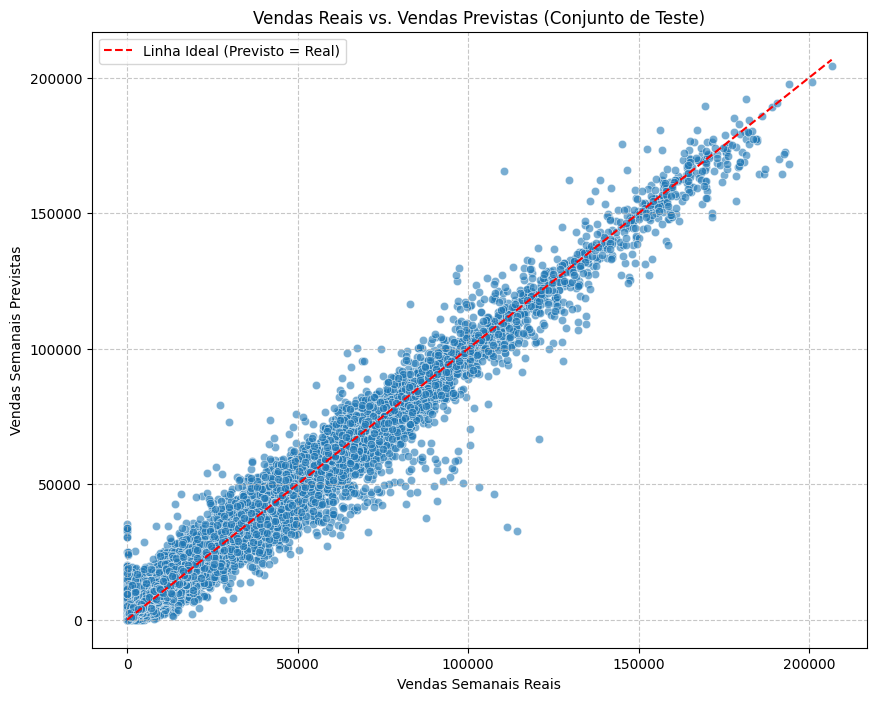

In [8]:
#Gráfico de Dispersão: Vendas Reais vs. Vendas Previstas
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Weekly_Sales_Actual', y='Weekly_Sales_Predicted', data=df_test_analysis, alpha=0.6)
plt.plot([df_test_analysis['Weekly_Sales_Actual'].min(), df_test_analysis['Weekly_Sales_Actual'].max()],
         [df_test_analysis['Weekly_Sales_Actual'].min(), df_test_analysis['Weekly_Sales_Actual'].max()],
         color='red', linestyle='--', label='Linha Ideal (Previsto = Real)')
plt.title('Vendas Reais vs. Vendas Previstas (Conjunto de Teste)')
plt.xlabel('Vendas Semanais Reais')
plt.ylabel('Vendas Semanais Previstas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

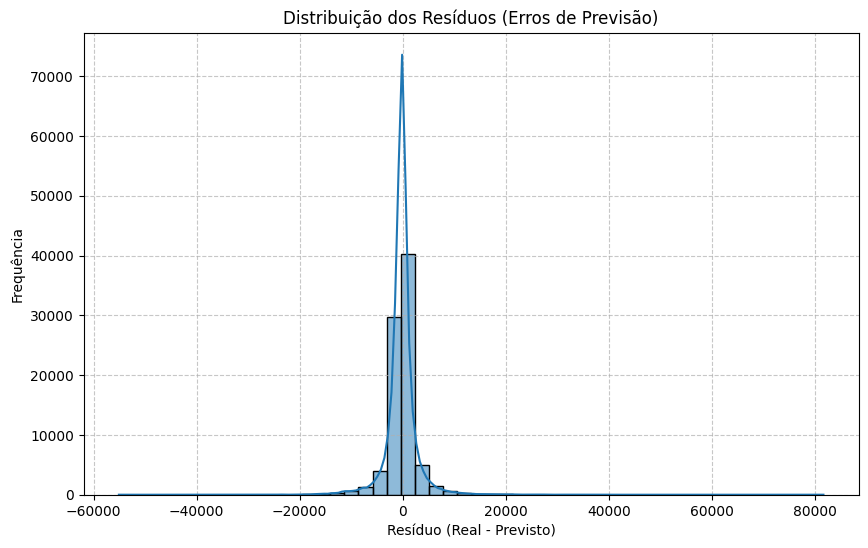

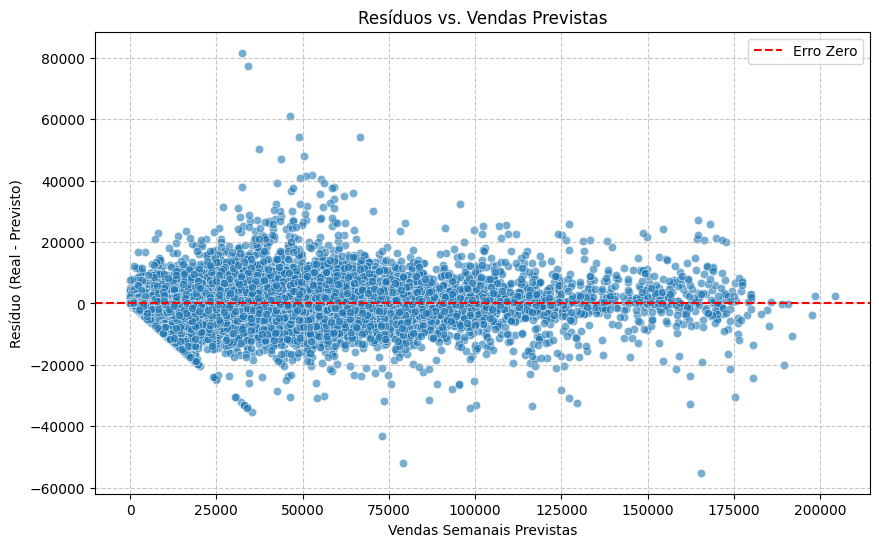

In [9]:
#Gráfico de Resíduos
plt.figure(figsize=(10, 6))
sns.histplot(df_test_analysis['Residual'], bins=50, kde=True)
plt.title('Distribuição dos Resíduos (Erros de Previsão)')
plt.xlabel('Resíduo (Real - Previsto)')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Weekly_Sales_Predicted', y='Residual', data=df_test_analysis, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', label='Erro Zero')
plt.title('Resíduos vs. Vendas Previstas')
plt.xlabel('Vendas Semanais Previstas')
plt.ylabel('Resíduo (Real - Previsto)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


Análise de Desempenho por Dimensão:


<Figure size 1200x600 with 0 Axes>

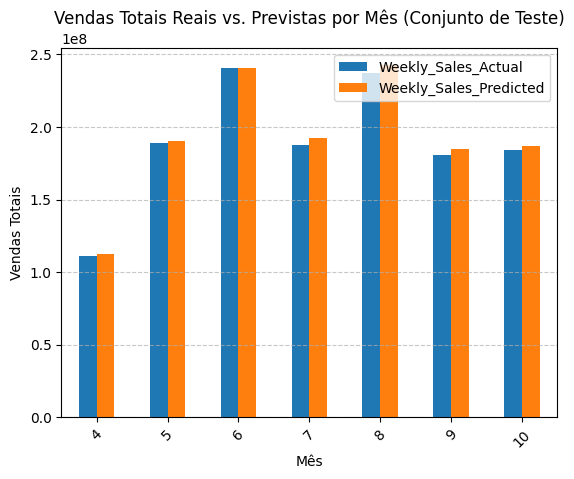

In [10]:
#Comparação Agregada
print("\nAnálise de Desempenho por Dimensão:")

monthly_comparison = df_test_analysis.groupby('Month')[['Weekly_Sales_Actual', 'Weekly_Sales_Predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
monthly_comparison.plot(x='Month', y=['Weekly_Sales_Actual', 'Weekly_Sales_Predicted'], kind='bar')
plt.title('Vendas Totais Reais vs. Previstas por Mês (Conjunto de Teste)')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

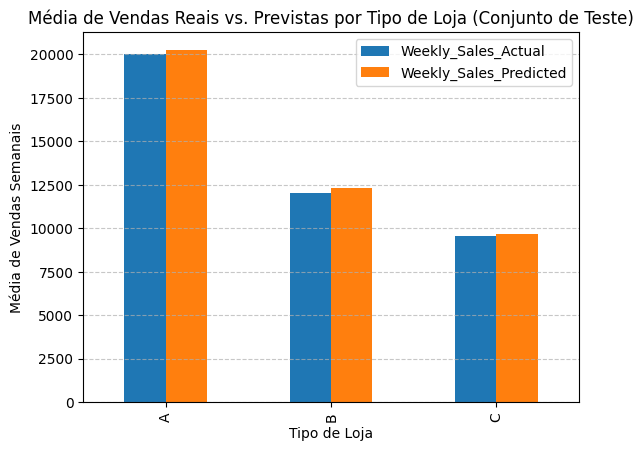


=== Módulo de Análise de Desempenho Concluído ===


In [11]:
type_comparison = pd.merge(df_test_analysis, df_stores[['Store', 'Type']].drop_duplicates(), on='Store', how='left')
type_comparison = type_comparison.groupby('Type_x')[['Weekly_Sales_Actual', 'Weekly_Sales_Predicted']].mean().reset_index()

plt.figure(figsize=(10, 6))
type_comparison.plot(x='Type_x', y=['Weekly_Sales_Actual', 'Weekly_Sales_Predicted'], kind='bar')
plt.title('Média de Vendas Reais vs. Previstas por Tipo de Loja (Conjunto de Teste)')
plt.xlabel('Tipo de Loja')
plt.ylabel('Média de Vendas Semanais')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n=== Módulo de Análise de Desempenho Concluído ===")